In [116]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [117]:
path = 'C:/Users/Chloé/Desktop/csulb/lfw'

In [118]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [119]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


torch.Size([250, 250, 3])


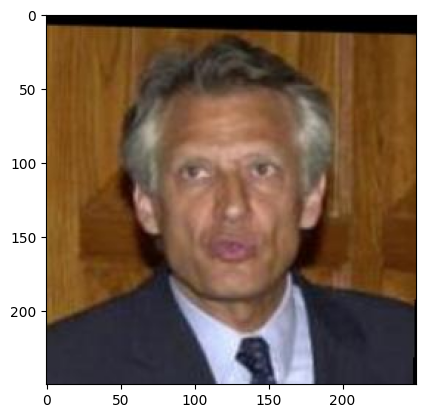

In [120]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

Sample Image Shape: (250, 250, 3)


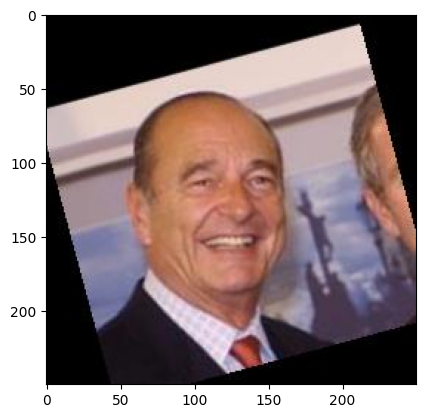

In [121]:
sample_image, _ = next(iter(dataloader))
sample_image = sample_image[0].permute(1, 2, 0).numpy()

print("Sample Image Shape:", sample_image.shape)

plt.imshow(sample_image)
plt.show()


The first 250 might be related to height, second 250 related to width and the last element, 3, to the number of channels in each image (if 3 here, we can suppose it's RGB)

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [122]:
import torch
import torch.nn as nn

class AE(nn.Module):
    
    def __init__(self):
        super(AE, self).__init__()
        
        # Encoder layers
        self.encoder_conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.encoder_bn1 = nn.BatchNorm2d(64)
        self.encoder_relu1 = nn.ReLU()
        
        self.encoder_conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=2, padding=1)
        self.encoder_bn2 = nn.BatchNorm2d(128)
        self.encoder_relu2 = nn.ReLU()

        # Decoder layers
        self.decoder_conv1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, output_padding=0)
        self.decoder_bn1 = nn.BatchNorm2d(64)
        self.decoder_relu1 = nn.ReLU()
        
        self.decoder_conv2 = nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=2, stride=2, padding=1, output_padding=0)
        self.decoder_bn2 = nn.BatchNorm2d(3)
        self.decoder_sigmoid = nn.Sigmoid()

    def encoder(self, x):
        x = self.encoder_conv1(x)
        x = self.encoder_bn1(x)
        x = self.encoder_relu1(x)

        x = self.encoder_conv2(x)
        x = self.encoder_bn2(x)
        x = self.encoder_relu2(x)

        return x

    def decoder(self, x):
        x = self.decoder_conv1(x)
        x = self.decoder_bn1(x)
        x = self.decoder_relu1(x)

        x = self.decoder_conv2(x)
        x = self.decoder_bn2(x)
        x = self.decoder_sigmoid(x)

        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x


In [123]:
import torch
import torch.nn as nn

class AE(nn.Module):
    
    def __init__(self):
        super(AE, self).__init__()

        # Encoder layers
        self.encoder_conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.encoder_bn1 = nn.BatchNorm2d(64)
        self.encoder_relu1 = nn.ReLU()
        
        self.encoder_conv2 = nn.Conv2d(64, 128, kernel_size=2, stride=2, padding=1)
        self.encoder_bn2 = nn.BatchNorm2d(128)
        self.encoder_relu2 = nn.ReLU()

        # Decoder layers
        self.decoder_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=0)
        self.decoder_bn1 = nn.BatchNorm2d(64)
        self.decoder_relu1 = nn.ReLU()
        
        self.decoder_conv2 = nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2, padding=1, output_padding=0)
        self.decoder_bn2 = nn.BatchNorm2d(3)
        self.decoder_sigmoid = nn.Sigmoid()

    def encoder(self, x):
        x = self.encoder_conv1(x)
        x = self.encoder_bn1(x)
        x = self.encoder_relu1(x)

        x = self.encoder_conv2(x)
        x = self.encoder_bn2(x)
        x = self.encoder_relu2(x)

        return x

    def decoder(self, x):
        x = self.decoder_conv1(x)
        x = self.decoder_bn1(x)
        x = self.decoder_relu1(x)

        x = self.decoder_conv2(x)
        x = self.decoder_bn2(x)
        x = self.decoder_sigmoid(x)

        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [124]:
model = AE()

In [125]:
data_iterator = iter(dataloader)
images, _ = next(data_iterator)

# Print the shape of the input image
print("Input image shape:", images.shape)

# Forward pass through the model
output = model(images)

# Print the shape of the output of the encoder
encoded_output = model.encoder(images)
print("Encoded output shape:", encoded_output.shape)

# Print the shape of the output of the decoder
decoded_output = model.decoder(encoded_output)
print("Decoded output shape:", decoded_output.shape)

Input image shape: torch.Size([32, 3, 250, 250])
Encoded output shape: torch.Size([32, 128, 63, 63])
Decoded output shape: torch.Size([32, 3, 250, 250])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [126]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")


Total number of parameters: 168457


In [127]:
import torch.optim as optim

optim = optim.Adam(model.parameters(), lr=0.001)

In [128]:
loss_function = nn.MSELoss()

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [129]:
# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    total_loss = 0.0

    for batch_idx, (images, _) in enumerate(dataloader):
        # Zero the gradients
        optim.zero_grad()

        # Forward pass
        outputs = model(images)

        # Compute the loss
        loss = loss_function(outputs, images)

        # Backward pass
        loss.backward()

        # Update the weights
        optim.step()

        total_loss += loss.item()


    # Print the average loss at the end of each epoch
    average_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}")


Epoch 1/10, Loss: 0.013387954829863592


##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

In [ ]:
model = AE()

model.eval()


for images, _ in dataloader:
    original_image = images[0]

    with torch.no_grad():
        reconstructed_image = model(original_image)

    
    original_image = original_image.permute(1, 2, 0).numpy()  
    reconstructed_image = reconstructed_image[0].permute(1, 2, 0).numpy()

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(original_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Reconstructed Image')
    plt.imshow(reconstructed_image)
    plt.axis('off')

    plt.show()
    break  


##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

In [ ]:
model = AE()
model.eval()

for images, _ in dataloader:
    original_image = images[0]

    with torch.no_grad():
        encoded_image = model.encoder(original_image)

    noise = torch.randn_like(encoded_image) * 0.1  
    noisy_encoded_image = encoded_image + noise

    with torch.no_grad():
        reconstructed_image = model.decoder(noisy_encoded_image)

    original_image = original_image.permute(1, 2, 0).numpy()
    reconstructed_image = reconstructed_image[0].permute(1, 2, 0).numpy()
    noisy_encoded_image = noisy_encoded_image[0].permute(1, 2, 0).numpy()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(original_image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Noisy Encoded Image')
    plt.imshow(noisy_encoded_image)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Reconstructed Image from Noisy Encoding')
    plt.imshow(reconstructed_image)
    plt.axis('off')

    plt.show()
    break 
